In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

import matplotlib.pyplot as plt
import os
from sklearn.metrics import confusion_matrix

from tqdm import tqdm
tqdm.monitor_interval = 0

In [3]:
PATH = "data/"

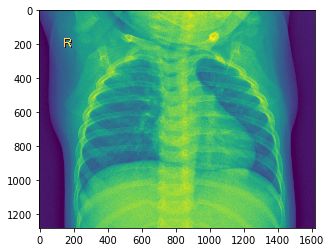

In [4]:
normal_example = os.listdir(f'{PATH}train/NORMAL')[4]
normal_img = plt.imread(f'{PATH}train/NORMAL/{normal_example}')
plt.imshow(normal_img)

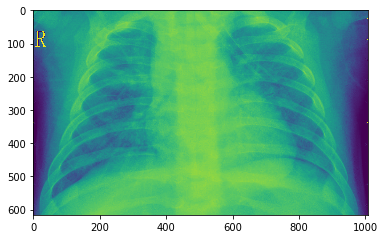

In [5]:
pneumonia_example = os.listdir(f'{PATH}train/PNEUMONIA')[6]
pneumonia_img = plt.imread(f'{PATH}train/PNEUMONIA/{pneumonia_example}')
plt.imshow(pneumonia_img)

In [6]:
size = 299
batch_size = 64
arch = resnet34

In [7]:
def get_data(size, bs):
    tfms = tfms_from_model(arch, size, aug_tfms=transforms_side_on, max_zoom=1.3)
    data = ImageClassifierData.from_paths(PATH, bs=batch_size, tfms=tfms, val_name='val',
                                          test_name="test", test_with_labels=True)
    return data

In [8]:
data = get_data(size, batch_size)
model = ConvLearner.pretrained(arch, data, precompute=False)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 93%|█████████████████████████████████████████████████████████████████▊     | 76/82 [01:52<00:08,  1.48s/it, loss=2.89]


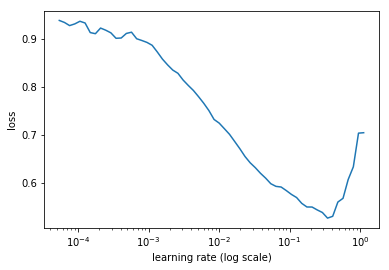

In [9]:
lr_finder = model.lr_find()
model.sched.plot()

In [10]:
lr = 1e-2
model.fit(lr, 2, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.288287   0.35283    0.8125    
    1      0.20869    0.189666   0.9375                                                                                



[0.18966558575630188, 0.9375]

In [11]:
model.unfreeze()
lrs = np.array([lr/100, lr/10, lr])
model.fit(lrs, 2, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                                                                              
    0      0.196659   0.18394    0.9375    
    1      0.167506   0.179463   0.9375                                                                                
    2      0.138427   0.175345   0.9375                                                                                



[0.1753448247909546, 0.9375]

In [12]:
log_probs, y = model.TTA(is_test=True)
probs = np.mean(np.exp(log_probs), axis=0)

In [13]:
test_accuracy = round(accuracy_np(probs, y), 3)
print(f"Test accuracy: {test_accuracy}")

Test accuracy: 0.921


[[190  44]
 [  5 385]]


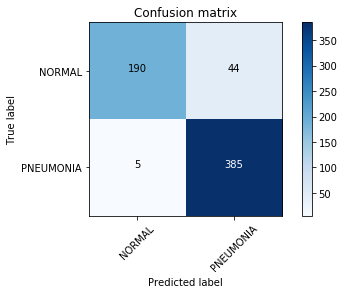

In [14]:
preds = np.argmax(probs, axis=1)
cm = confusion_matrix(y, preds)
plot_confusion_matrix(cm, data.classes)